In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from Element_PI import VariancePersistv1
import glob
from sklearn.model_selection import train_test_split


Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
px = 32
py = 32
spread = 1      #varience or std, not sure
axis_bound = 2.5  #angstroms
samples = 500

data_path = '../iMoDELS-supplements/data/raw-data/everything.csv'
data = pd.read_csv(data_path, index_col=0)
data = data.drop(['backbone'],axis=1)

molecules = glob.glob('../terminal_group_screening/src/util/molecules/*.xyz')
molecules = list(set(molecules))
im_mols = {}
for m in molecules:
    mol_name = m.split('/')[-1].split('.')[0]
    if 'ch3' in mol_name:
        mol_name = mol_name.split('-')[0]
        im_mols[mol_name] = VariancePersistv1(m, pixelx=px, pixely=py, myspread=spread, myspecs={"maxBD": axis_bound, "minBD":-.10}, showplot=False).reshape(px,py, 1)
        im_mols[mol_name] = np.asarray(im_mols[mol_name]).astype('float32')

def str_to_im(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        return im_mols[chem_name]
        
data.terminal_group_1 = data.terminal_group_1.apply(str_to_im)
data.terminal_group_2 = data.terminal_group_2.apply(str_to_im)
data.terminal_group_3 = data.terminal_group_3.apply(str_to_im)
data = data.dropna()


msk = np.random.rand(len(data)) < 0.8
train, test = data[msk] , data[~msk]

train_X, train_y = train, train['COF']
train_X = train_X.drop(['COF'],axis=1)
test_X, test_y = test, test['COF']

In [8]:
input_t1 = keras.Input(shape=(px, py, 1))
x = keras.layers.Conv2D(16, 5)(input_t1)
x = keras.layers.Conv2D(16, 4)(x)
x = keras.layers.Conv2D(16, 3)(x)
x = keras.layers.Dense(16)(x)
out = keras.layers.Dense(1,activation='linear')(x)
model = keras.Model(inputs = input_t1, outputs=out)
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
model.fit(np.array(train_X['terminal_group_1'].to_list()), np.array(train_y.to_list()), epochs=5, verbose=1)

Epoch 1/5
146/146 [==============================] - 8s 49ms/step - loss: 5.7084e-04 - accuracy: 0.0000e+00
Epoch 2/5
146/146 [==============================] - 7s 50ms/step - loss: 2.8846e-04 - accuracy: 0.0000e+00
Epoch 3/5
146/146 [==============================] - 7s 50ms/step - loss: 2.6501e-04 - accuracy: 0.0000e+00
Epoch 4/5
146/146 [==============================] - 7s 51ms/step - loss: 2.6199e-04 - accuracy: 0.0000e+00
Epoch 5/5
146/146 [==============================] - 8s 52ms/step - loss: 2.5528e-04 - accuracy: 0.0000e+00


In [5]:
input_t1 = keras.Input(shape=(px, py, 1))
x = keras.layers.Conv2D(8, 5)(input_t1)
x = keras.layers.Conv2D(8, 4)(x)
x = keras.layers.Conv2D(8, 3)(x)
x = keras.layers.Flatten()(x)
model_x = keras.Model(inputs = input_t1, outputs=x)

input_t2 = keras.Input(shape=(px, py, 1))
y = keras.layers.Conv2D(8, 5)(input_t2)
y = keras.layers.Conv2D(8, 4)(y)
y = keras.layers.Conv2D(8, 3)(y)
y = keras.layers.Flatten()(y)
model_y = keras.Model(inputs = input_t2, outputs=y)

input_t3 = keras.Input(shape=(px, py, 1))
z = keras.layers.Conv2D(8, 5)(input_t3)
z = keras.layers.Conv2D(8, 4)(z)
z = keras.layers.Conv2D(8, 3)(z)
z = keras.layers.Flatten()(z)
model_z = keras.Model(inputs = input_t3, outputs=z)

meta_dat = keras.Input(shape=(111,))
m = keras.layers.Dense(128, activation ='relu')(meta_dat)
m = keras.layers.Dense(128, activation ='relu')(m)
model_m = keras.Model(inputs = meta_dat, outputs=m)

combo = keras.layers.concatenate([model_x.output, model_y.output, model_z.output, model_m.output])

out = keras.layers.Dense(256, activation='relu')(combo)
out = keras.layers.Dense(1, activation='linear')(out)

model = keras.Model(inputs=[input_t1, input_t2, input_t3, meta_dat], outputs=out)
model.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])
model.fit(
    x = [np.array(train_X['terminal_group_1'].to_list()),
    np.array(train_X['terminal_group_2'].to_list()),
    np.array(train_X['terminal_group_3'].to_list()),
    np.array(train_X[train_X.columns[3:].to_list()])], 
    y = np.array(train_y.to_list()),
    epochs=10,
    validation_data=([np.array(test_X['terminal_group_1'].to_list()),
    np.array(test_X['terminal_group_2'].to_list()),
    np.array(test_X['terminal_group_3'].to_list()),
    np.array(test_X[train_X.columns[3:].to_list()])], np.array(test_y.to_list())))

Epoch 1/10
148/148 [==============================] - 19s 120ms/step - loss: 3.3526 - accuracy: 0.0000e+00 - val_loss: 0.0161 - val_accuracy: 0.0000e+00
Epoch 2/10
148/148 [==============================] - 18s 125ms/step - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 3/10
148/148 [==============================] - 19s 125ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 4/10
148/148 [==============================] - 19s 126ms/step - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0471 - val_accuracy: 0.0000e+00
Epoch 5/10
148/148 [==============================] - 18s 124ms/step - loss: 0.0594 - accuracy: 0.0000e+00 - val_loss: 0.0116 - val_accuracy: 0.0000e+00
Epoch 6/10
148/148 [==============================] - 19s 128ms/step - loss: 0.0073 - accuracy: 0.0000e+00 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 7/10
148/148 [==============================] - 18s 125ms/step - loss: 0.002

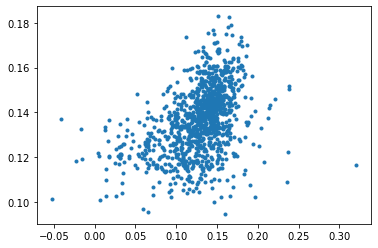

In [8]:
test_pred = model([np.array(test_X['terminal_group_1'].to_list()),
    np.array(test_X['terminal_group_2'].to_list()),
    np.array(test_X['terminal_group_3'].to_list()),
    np.array(test_X[train_X.columns[3:].to_list()])], np.array(test_y.to_list()))
plt.plot(test_pred, test_y,'.')